### Inicialização

- Coloque seu kaggle.json no File System do Colab
- Descomente os comandos abaixo ao rodar pela primeira vez

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
# !chmod 600 '/content/kaggle.json'
# !kaggle datasets download -d mariafrenti/age-prediction

 99% 2.01G/2.03G [00:17<00:00, 145MB/s]
100% 2.03G/2.03G [00:17<00:00, 125MB/s]


In [ ]:
# !unzip -q age-prediction.zip

In [ ]:
# !rm age-prediction.zip

### Importação

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2303598646551248814
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6909083869459965505
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [164]:
SEED = 1001

import numpy as np
import pandas as pd
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import tensorflow as tf
import random as python_random
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import math
# Typings
from typing import Tuple, Callable, List, Union, Dict, Iterable, Iterator, Optional
from tensorflow.python.data.ops.dataset_ops import BatchDataset
import functools

# Padronizando a aleatoriedade
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Comandos úteis

#### Salvar pasta

In [ ]:
#!zip -r /content/folder.zip /content/folder
#from google.colab import files
#files.download("/content/folder.zip")

#### Carregar modelo

In [ ]:
#!unzip -q 20062022r.zip

In [ ]:
#_load_model = keras.models.load_model('./content/20062022r')

### Carregamento dos dados de treino

In [165]:
NUM_OF_COLOR_CHANNELS = 3
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 8
INPUT_SHAPE = (*IMAGE_SIZE, NUM_OF_COLOR_CHANNELS)
BATCH_INPUT_SHAPE = (None, *INPUT_SHAPE)

'''
    Retorna um Dataset com base nos arquivos dos diretórios.
    - path: caminho base para as pastas
'''
def _load_data(path: str) -> tf.data.Dataset:
    return keras.preprocessing.image_dataset_from_directory(
        path,
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
_20to50_dir = "20-50/20-50"
_1to100_dir = "age_prediction_up/age_prediction"


'''
    Retorna um Dataset com as imagens e labels já apropriados para treinamento
    - all_ages: se deve ser usado o diretório com idades de 1 a 100
    - train: se deve ser usado o conjunto de treino
    (será usado teste caso contrário)
    - regression: se os labels devem ser transformados para tarefas de regressão
    (será transformado para classificação caso contrário)
'''
def load_data(all_ages: bool, train: bool, regression: bool) -> tf.data.Dataset:
    base_dir = _1to100_dir if all_ages else _20to50_dir
    folder = "train" if train else "test"
    age_count = 100 if all_ages else 31
    data = _load_data(path=f"{base_dir}/{folder}")
    if regression:
        return data.map(lambda x, y: (x, y / (age_count - 1)))
    return data.map(lambda x, y: (x, tf.one_hot(y, depth=age_count)))

In [166]:
train_data = load_data(all_ages=True, train=False, regression=True)
train_data

Found 47568 files belonging to 100 classes.


<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [170]:
'''
    Mapeia labels ou predições, que são valores em [0, 1], para idades.
    Na classificação, há codificação one-hot

    A idade retornada na classificação é aquela associada à classe
    com maior propabilidade.
'''
def map_to_ages(labels, all_ages: bool, regression: bool):
    scale = (99 if all_ages else 30) if regression else 1
    offset = 1 if all_ages else 20
    if not regression:
        labels = np.argmax(labels, axis=-1)
    return labels * scale + offset

# Exemplo com labels
for i in range(2):
    _first_batch_labels = next(iter(train_data))[1]
    print(map_to_ages(_first_batch_labels, all_ages=True, regression=True))

# Exemplo com predições (one-hot-encoding)
_preds = np.zeros(100)
_preds[7] = 0.6 # Idade 8 é a de maior probabilidade
_preds[9] = 0.3
_preds[10] = 0.1
_preds2 = np.zeros(100)
_preds2[2] = 1 # Idade 3 é a de maior probabilidade
print(map_to_ages([_preds, _preds2], all_ages=True, regression=False))

tf.Tensor([48. 27. 30. 31. 23.  7. 27. 66.], shape=(8,), dtype=float64)
tf.Tensor([21. 66. 32. 38. 31. 35. 44. 37.], shape=(8,), dtype=float64)
[8 3]


### Pipeline de pré-processamento

In [ ]:
_only_normalization = keras.Sequential([
    layers.Rescaling(1./255, batch_input_shape=BATCH_INPUT_SHAPE)
], name='only_normalization')
preprocess = keras.Sequential(
    [
        layers.Resizing(*IMAGE_SIZE, batch_input_shape=BATCH_INPUT_SHAPE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        _only_normalization,
    ], name='preprocess'
)


### Visualizando imagens

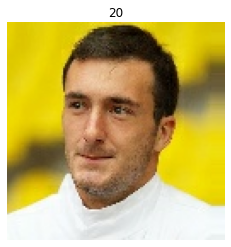

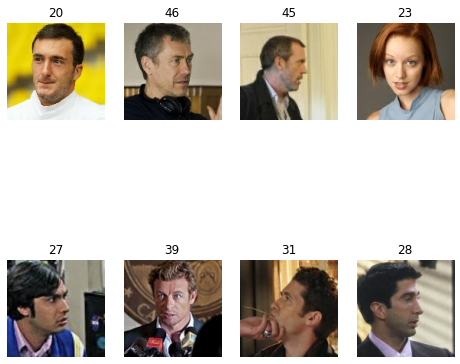

In [ ]:
def batchify(image: np.ndarray) -> np.ndarray:
    if len(image.shape) == len(INPUT_SHAPE):
        # o modelo (incluindo pré-processamento) espera a entrada em mini-batches
        # caso uma única imagem seja passada, modificamos seu formato
        # para 1 batch de 1 imagem
        image = np.expand_dims(image, axis=0)
    return image

'''
    Exibe uma image.
'''
def plot_single_image(image: np.ndarray, age: Optional[int] = None, apply=None):
    if apply is not None:
        image = apply(batchify(image))[0]
    fig, ax = plt.subplots()
    ax.imshow(image)
    if age is not None:
        ax.set_title(age)
    ax.axis("off")

def plot_samples(images, ages: Iterable[int], ncols=4, apply=None):
    if ncols > len(images):
        ncols = len(images)
    nrows = math.ceil(len(images) / ncols)
    N = nrows * ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8), squeeze=False)
    axs = axs.ravel()
    for i, (image, age) in enumerate(zip(images, ages)):
        if i >= N:
            break
        image = image.numpy().astype('uint8')
        if apply is not None:
            image = apply(batchify(image))[0]
        axs[i].imshow(image)
        axs[i].set_title(age)
        axs[i].axis("off")

plot_single_image(first_batch_images[0], first_batch_labels[0], apply=_only_normalization)
plot_samples(first_batch_images, first_batch_labels)

Verificando o pipeline de data augmentation com 4 imagens

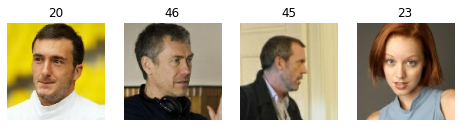

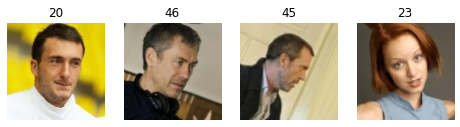

In [ ]:
_N = 4
plot_samples(first_batch_images[:_N], first_batch_labels[:_N], ncols=_N, apply=_only_normalization)
plot_samples(first_batch_images[:_N], first_batch_labels[:_N], ncols=_N, apply=preprocess)

### Modelo

Construção do modelo de maneira programática

In [ ]:
def build_model(
    inputs,
    num_of_conv_layers_per_block: int,
    num_of_blocks: int,
    initial_filter: int,
    num_of_hidden_layers: int,
    neurons_per_hidden_layer: int, 
    dense_activation: str,
    output_activation: str,
    dropout: Optional[float] = None,
    # se o número de filtros é constante ou dobra a cada bloco
    fixed_size_filter: bool = False,
    use_batch_normalization = False,
):
    dropout = None if dropout == 0 else dropout
    if dropout is not None and use_batch_normalization:
        print("[WARNING] Não é recomendado usar Dropout com BatchNormalization")

    KERNEL_SIZE = 3
    CONV_ACTIVATION = 'relu'
    CONV_PADDING = 'same'
    POOL_SIZE = 2
    BATCH_INPUT_SHAPE = (*IMAGE_SIZE, 3)

    x = preprocess(inputs)

    all_blocks = []
    filters = initial_filter
    for i in range(num_of_blocks):
        all_blocks.append([
            *(
                layers.Conv2D(filters, KERNEL_SIZE, padding=CONV_PADDING, batch_input_shape=BATCH_INPUT_SHAPE)
                for j in range(num_of_conv_layers_per_block)
            ),
            layers.MaxPooling2D(pool_size=POOL_SIZE)
        ])
        if not fixed_size_filter:
            filters *= 2
    
    for block in all_blocks:
        for layer in block:
            x = layer(x)
        if use_batch_normalization:
            x = layers.BatchNormalization()(x)
    
    if dropout is not None:
        x = layers.Dropout(dropout)(x)
    x = layers.Flatten()(x)

    for i in range(num_of_hidden_layers):
        x = layers.Dense(neurons_per_hidden_layer, activation=dense_activation)(x)

    x = layers.Dense(1, activation=output_activation)(x)
        
    return keras.models.Model(inputs=inputs, outputs=x)

Exemplo de construção

In [ ]:
build_model(
    layers.Input(shape=(None, None, 3), dtype='uint8'),
    num_of_conv_layers_per_block = 2,
    num_of_blocks = 2,
    initial_filter = 16,
    num_of_hidden_layers = 2,
    neurons_per_hidden_layer = 128,
).summary()

In [ ]:
def get_random_hyperparameters(count: int, seed: int = 3621263):
    rng = np.random.default_rng(seed=seed)
    for i in range(count):
        yield {
            'num_of_conv_layers_per_block': rng.choice([1, 2, 3]),
            'num_of_blocks': rng.choice([1, 2, 3, 4]),
            'num_of_hidden_layers': rng.choice([1, 2, 3, 4]),
            'neurons_per_hidden_layer': rng.choice([16, 32, 64, 128, 256, 512]),
            'initial_filter': rng.choice([8, 16, 32, 64, 128]),
            'dropout': rng.choice([0, 0.1, 0.5]),
            'fixed_size_filter': rng.choice([False, True]),
            'use_batch_normalization': rng.choice([False]),
            'dense_activation': rng.choice(['tanh', 'relu']),
        }

list(get_random_hyperparameters(2, seed=1))

In [ ]:
def train_model_R(model, epochs: int):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.MSE
    model.compile(optimizer=optimizer, loss=loss)
    return model.fit(train_data_R, epochs=epochs, validation_data=valid_data_R)


Exemplo de uso das funções.
Será feito um Random Search.

In [ ]:
inputs = layers.Input(shape=(None, None, 3), dtype='uint8')
model = build_model(inputs, **next(get_random_hyperparameters(1)))
history = train_model(model, epochs=2)

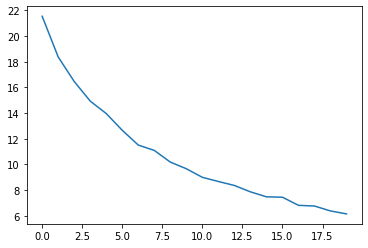

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
class Losses:
    @staticmethod
    def RMSE(real: np.ndarray, pred: np.ndarray) -> float:
        return np.sqrt(np.mean((real - pred) ** 2))

    @staticmethod
    def MAE(real: np.ndarray, pred: np.ndarray) -> float:
        return np.mean(np.abs(real - pred))
    
    @staticmethod
    def regression(real: np.ndarray, pred: np.ndarray) -> pd.Series:
        return pd.Series({
            'RMSE': Losses.RMSE(real, pred),
            'MAE': Losses.MAE(real, pred),
        }, name='losses')

Visualizando a predição do modelo

Idades preditas: [31 37 45 38 33 29 34 29]
RMSE    8.624094
MAE     7.125000
Name: losses, dtype: float64


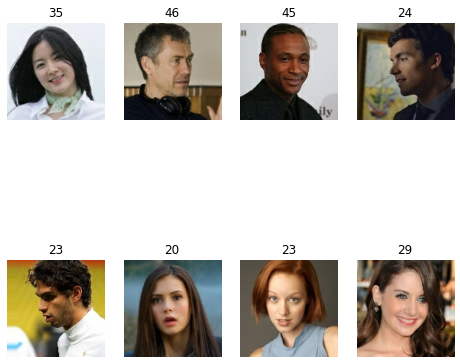

In [ ]:

def visualize_predictions(model, source):
    _images, _ages = list(source.take(1))[0]
    _ages = transform_labels(_ages)
    plot_samples(_images, _ages)
    _pred = model.predict(_images)
    _pred = transform_labels(_pred)

    print('Idades preditas:', _pred)
    print(Losses.regression(_pred, _ages))

visualize_predictions(model, train_data)

Idades preditas: [31 20 20 22 26 47 42 32]
RMSE    15.398864
MAE     12.125000
Name: losses, dtype: float64


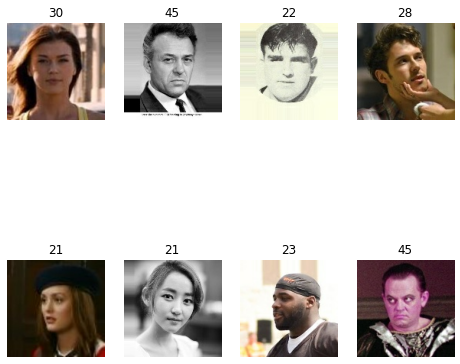

In [ ]:
visualize_predictions(model, valid_data)

In [ ]:
# Regressão
inputs_R = layers.Input(shape=(None, None, 3), dtype='uint8')
model_amount = 100
epochs_R = 10
models_R = []
loss_R = np.ndarray(model_amount)
hyperparams_R = list(get_random_hyperparameters(count=model_amount))
model_amount = 100
for i in range(model_amount):
  model_R = build_model(inputs_R, **hyperparams_R[i])
  history_R = train_model_R(model_R, epochs_R)
  models_R.append(model_R)
  loss_R[i] = history_R.history['val_loss'][-1]
idx_R = np.argmin(loss_R)

In [ ]:
# Classificação
inputs_C = layers.Input(shape=(None, None, 3), dtype='uint8')
models_C = []
hyperparams_C = []
loss_C = []